# Neural network for 2D transport problem

### Imports

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split
from google.colab import files
import matplotlib.pyplot as plt

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Auxiliary functions

In [18]:
def plot_history(history):
  fig = plt.figure(figsize=(6,4), dpi=100)
  plt.xlabel('Epoch')
  plt.ylabel('MSE (averaged)')
  plt.semilogy(history.epoch, np.array(history.history['loss']), color = 'blue', 
           label='Training set')
  plt.semilogy(history.epoch, np.array(history.history['val_loss']), color = 'red',
           label = 'Validation set')
  plt.legend()
  plt.show()
  #ylim([0.1,max(history.history['val_loss'])])
  fig.savefig("history.png", dpi=500)
  files.download("history.png") 

def unflatten(vec, coarse=False):
  if coarse:
    N = 40
  else: 
    N = 100
  return np.reshape(vec,(N+1, N+1))


### Loading the data

In [4]:
x = np.loadtxt('drive/MyDrive/colab_data/2D/coarse.csv', delimiter=',')
y = np.loadtxt('drive/MyDrive/colab_data/2D/fine.csv', delimiter=',')
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=33) 

int_dim = x.shape[1]
out_dim = y.shape[1]

print(f'input dim: {int_dim}')
print(f'output dim: {out_dim}')

input dim: 1681
output dim: 10201


### The network

In [7]:
#xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.10)

act = "relu" # tanh activation function

model = Sequential()
model.add(Dense(100, input_dim=int_dim, activation = act))
model.add(Dense(64, activation = act))
model.add(Dense(64, activation = act))
model.add(Dense(64, activation = act))
model.add(Dense(out_dim, activation = "sigmoid"))
model.compile(loss="mse", optimizer="adam")

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 100)               168200    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 10201)             663065    
Total params: 846,049
Trainable params: 846,049
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(xtrain, ytrain, epochs=500, batch_size=32, verbose=0, validation_split=0.2)

In [12]:
ypred = model.predict(xtrain)
training_loss = tf.keras.losses.MSE(ytrain, ypred)
print("train. loss: ", np.mean(training_loss))

ypred = model.predict(xtest)
test_loss = tf.keras.losses.MSE(ytest, ypred)
print("test. loss: ", np.mean(test_loss))
print("i=", np.argmax(test_loss))

print(test_loss[np.argmax(test_loss)])

train. loss:  1.3681268e-05
test. loss:  1.5003325e-05
i= 244
tf.Tensor(0.0002885707, shape=(), dtype=float32)


In [69]:
abs_max_err = np.zeros((500,))

for i in range(len(abs_max_err)):
  abs_max_err[i] = np.max(np.abs(ypred[i]-ytest[i]))

print("average MaAE", np.mean(abs_max_err))
print("max MaAE", np.max(abs_max_err))
print("min MaAE", np.min(abs_max_err))

average MaAE 0.02560347061788152
max MaAE 0.10915844422643062
min MaAE 0.010254132255779869


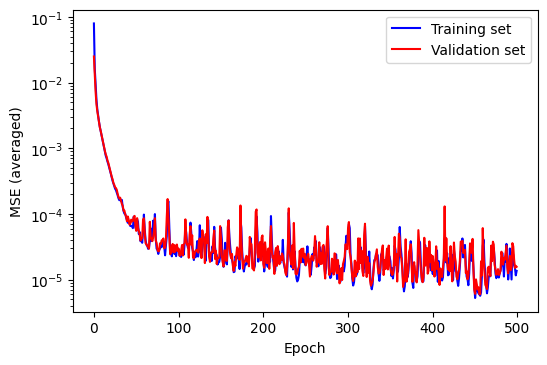

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
plot_history(history)

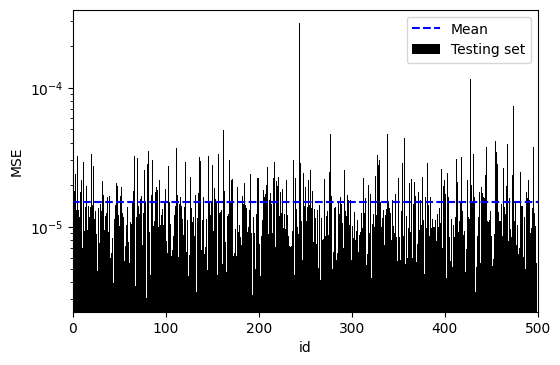

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
fig = plt.figure(figsize=(6,4), dpi=100)
i = np.arange(0,len(test_loss))
plt.bar(i, test_loss, width=1, color = 'black', label = f'Testing set')
plt.hlines(np.mean(test_loss), -1, 500, colors='blue', linestyles='--', label='Mean')
plt.xlabel('id')
plt.ylabel('MSE')
plt.yscale("log")
plt.xlim(0,500)
plt.legend(loc='best')
plt.show()
fig.savefig("demo.png", dpi=500)
files.download("demo.png") 

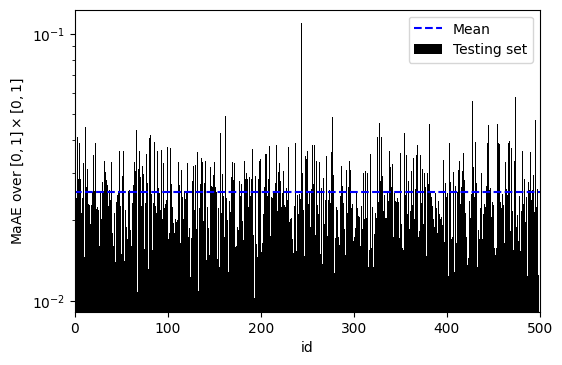

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
fig = plt.figure(figsize=(6,4), dpi=100)
i = np.arange(0,len(test_loss))
plt.bar(i, abs_max_err, width=1, color = 'black', label = f'Testing set')
plt.hlines(np.mean(abs_max_err), -1, 501, colors='blue', linestyles='--', label='Mean')
plt.xlabel('id')
plt.ylabel(r'MaAE over $[0,1] \times [0,1]$')
plt.yscale("log")
plt.xlim(0,500)
plt.legend(loc='best')
plt.show()
fig.savefig("demo.png", dpi=500)
files.download("demo.png") 

i= 392


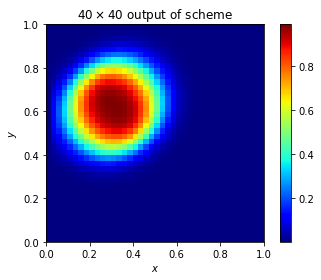

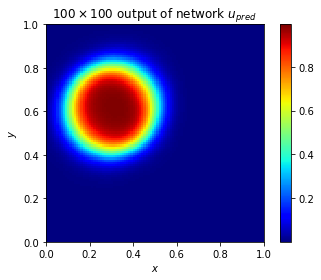

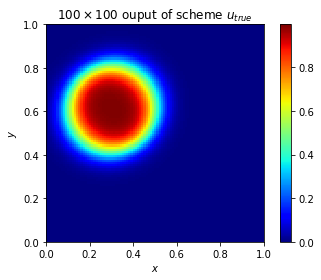

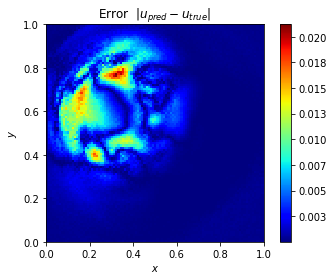

In [86]:
g = np.argsort(-test_loss)
i = g[249]
print("i=",i)

#i = 12

Ncoarse = 40
Nfine = 100
x = np.linspace(0,1,num=int(Ncoarse+1))
y = np.linspace(0,1,num=int(Ncoarse+1))
Xg, Yg = np.meshgrid(x, y) 
Z = unflatten(xtest[i], coarse=True)
fig=plt.figure()#figsize=(6,4),dpi=120)
ax = fig.add_subplot(111)
plt.pcolor(Xg, Yg, Z, cmap='jet')
cbar = plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
ax.set_aspect('equal', adjustable='box')
cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])
plt.title(r"$40\times 40$ output of scheme")
# plt.title('Coarse approx. of $u(x,y,T)$, $N=40$')
plt.show()

fig.savefig("demo.png", dpi=500)
# files.download("demo.png") 


######################################################

print('')

Ncoarse = 40
Nfine = 100
x = np.linspace(0,1,num=int(Nfine+1))
y = np.linspace(0,1,num=int(Nfine+1))
Xg, Yg = np.meshgrid(x, y) 
Z = unflatten(ypred[i], coarse=False)
fig2=plt.figure()#figsize=(6,4), dpi=120)
ax = fig2.add_subplot(111)
plt.pcolor(Xg, Yg, Z, cmap='jet')
cbar = plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
ax.set_aspect('equal', adjustable='box')
cbar.set_ticks([-1,0,0.2, 0.4, 0.6, 0.8, 1.0])
#plt.title('Output of network, $N=100$')
plt.title(r"$100\times 100$ output of network $u_{pred}$")
plt.show()

fig2.savefig("netout.png", dpi=500)
# files.download("netout.png") 

######################################################


Ncoarse = 40
Nfine = 100
x = np.linspace(0,1,num=int(Nfine+1))
y = np.linspace(0,1,num=int(Nfine+1))
Xg, Yg = np.meshgrid(x, y) 
Z = unflatten(ypred[i], coarse=False)
fig2=plt.figure()#figsize=(6,4), dpi=120)
ax = fig2.add_subplot(111)
plt.pcolor(Xg, Yg, Zref, cmap='jet')
cbar = plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
ax.set_aspect('equal', adjustable='box')
cbar.set_ticks([-1,0,0.2, 0.4, 0.6, 0.8, 1.0])
#plt.title('Output of network, $N=100$')
plt.title(r"$100\times 100$ ouput of scheme $u_{true}$")
plt.show()

fig2.savefig("target.png", dpi=500)
# files.download("netout.png") 

######################################################

print('')

Ncoarse = 40
Nfine = 100
x = np.linspace(0,1,num=int(Nfine+1))
y = np.linspace(0,1,num=int(Nfine+1))
Xg, Yg = np.meshgrid(x, y) 
Z = unflatten(ypred[i], coarse=False)
Zref = unflatten(ytest[i], coarse=False)
fig3=plt.figure()#figsize=(6,4), dpi=120)
ax = fig3.add_subplot(111)
plt.pcolor(Xg, Yg, np.abs(Z-Zref), cmap='jet')
cbar = plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
ax.set_aspect('equal', adjustable='box')
cbar.ax.set_yticklabels(["{:.3f}".format(i) for i in cbar.get_ticks()])
#cbar.set_ticks([0.2, 0.4, 0.6, 0.8, 1.0])
plt.title('Error  $|u_{pred} - u_{true}|$')
plt.show()
fig3.savefig("demo2.png", dpi=500)
# files.download("demo2.png") 

#fig.savefig("demo.png", dpi=400)
#files.download("demo.png") 